In [3]:

import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import segmentation_models as sm
import tensorflow as tf
from tf.keras.metrics import MeanIoU
import random

tf.compat.v1.disable_eager_execution()

# To install the segmentation models library: pip install -U segmentation-models
# If you are running into generic_utils error when loading segmentation models library
# watch this video to fix it: https://youtu.be/syJZxDtLujs
# Use the landcover_prepare_data.py to prepare your data. 
# e.g., divide images to smaller patches, svae only the patches with real labels, split to train and val. 

2970


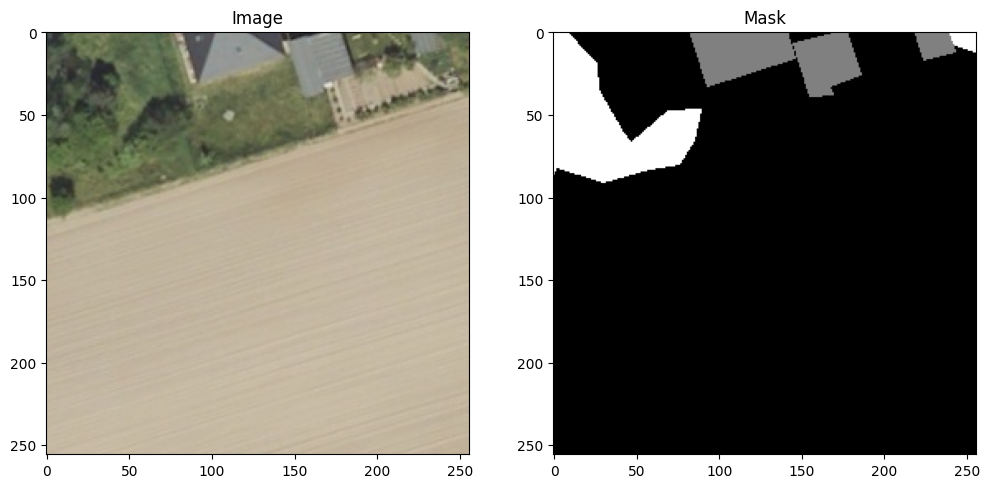

In [4]:
import os
os.chdir('/media/luismellow/Seagate Expansion Drive/Louis_work/02_Solidaridad_network/unet_cacau/')
#First try, using images from images, they didn't line up with the masks

train_img_dir = "data/data_for_keras_aug/train_images/train/"
train_mask_dir = "data/data_for_keras_aug/train_masks/train/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))
print(num_images)

img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

In [ ]:
# tf.compat.v1.disable_eager_execution() #in case the model gets very slow, may be due to a bug in TF2.0. Uncomment this. 
#https://github.com/tensorflow/tensorflow/issues/33024

#Also check this in case you notice training to be getting increasingly slow each epoch.
# https://stackoverflow.com/questions/53683164/keras-occupies-an-indefinitely-increasing-amount-of-memory-for-each-epoch


Found 2970 images belonging to 1 classes.
Found 2970 images belonging to 1 classes.


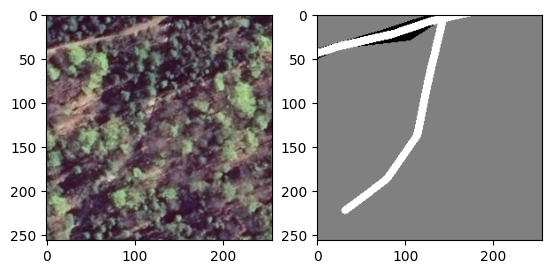

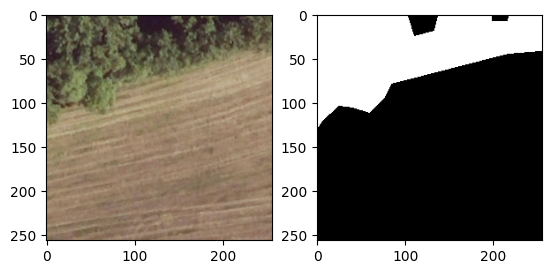

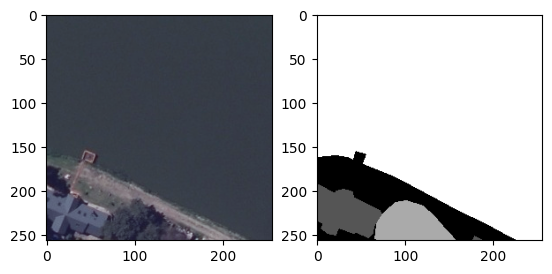

Found 3904 images belonging to 1 classes.
Found 3904 images belonging to 1 classes.


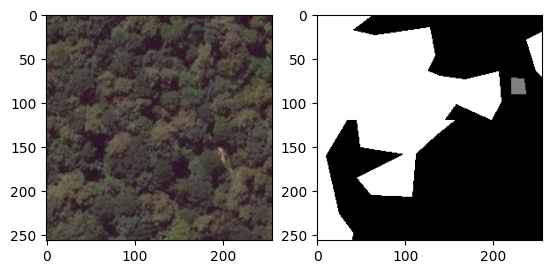

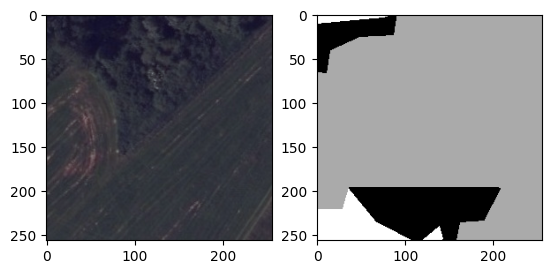

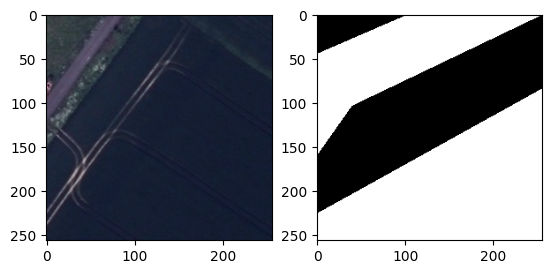

In [59]:
#importing pre_process from keras


# Define Generator for images and masks so we can read them directly from the drive. 
seed=24
batch_size= 16 #Se der erro de memória, diminuir o batch size
n_classes=5

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from keras.utils import to_categorical

#Use this to preprocess input for transfer learning
BACKBONE = 'resnet34' #pre trained weights are available for resnet34, resnet50, resnet101, resnet152, resnext50, resnext101, and seresnet50
preprocess_input = sm.get_preprocessing(BACKBONE) 

#Define a function to perform additional preprocessing after datagen.
#For example, scale images, convert masks to categorical, etc. 

def preprocess_data(img, mask, num_class):
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img)
    mask =  to_categorical(mask, num_class)

    return (img, mask)


#Define the generator.
#We are not doing any rotation or zoom to make sure mask values are not interpolated.
#It is important to keep pixel values in mask as 0, 1, 2, 3, .....
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def trainGenerator(train_img_path, train_mask_path, num_class) :
    
    #Data augmentation for images and masks, by horizontal and vertical flipping the images
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    # For each each image and mask, perform preprocessing and yield the pair
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)


train_img_path = "data/data_for_keras_aug/train_images/"
train_mask_path = "data/data_for_keras_aug/train_masks/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=5)

val_img_path = "data/data_for_keras_aug/val_images/"
val_mask_path = "data/data_for_keras_aug/val_masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=5)


x, y = train_img_gen.__next__()       
for i in range(0, 3):
    image =  x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.show()
  
  
    
x_val , y_val = val_img_gen.__next__()
for i in range(0,3):
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()



In [120]:

#Define a function to preprocess data.
#This function is called by the generator function.
def preprocess_data(img, mask, num_class):
        
        #Scale the image to 0-1 range
        img = img/255.0
        
        #Scale the mask to 0-1 range
        mask = mask/255.0
        
        #Convert mask to categorical
        mask = to_categorical(mask, num_classes=num_class)
        
        return img, mask
 
#Define the model
#We are using the Unet model with Resnet34 as the encoder.
#We are using the pretrained weights on imagenet dataset. 
#We are using the dice loss function and dice coefficient as the metric.
#We are using the Adam optimizer with learning rate 0.0001
def unet_model(n_classes, backbone, lr=0.0001, activation='softmax'):
    model = sm.Unet(backbone, classes=n_classes, activation=activation, encoder_weights='imagenet')
    model.compile(
        'Adam',
        loss=sm.losses.bce_jaccard_loss,
        metrics=[sm.metrics.iou_score],
    )
    return model

model = unet_model(n_classes,
                    BACKBONE,
                    lr=0.0001,
                    activation='softmax')

#Save the model
path_output = 'data/'
model_name = 'unet_landcover.h5'
model_path = os.path.join(path_output, model_name)
model.save(model_path)







#Build a u-net model with pre-trained backbone
def unet_model(n_classes, backbone='resnet34', encoder_weights='imagenet', input_height=256, input_width=256):
    model = sm.Unet(backbone, encoder_weights=encoder_weights, input_shape=(input_height, input_width, 3))
    model.compile(
        'Adam',
        loss=sm.losses.bce_jaccard_loss,
        metrics=[sm.metrics.iou_score],
    )
    return model

model = unet_model(n_classes=4, backbone='resnet34', encoder_weights='imagenet', input_height=256, input_width=256)

#Define callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#Save the model with best validation iou_score
model_checkpoint = ModelCheckpoint('unet_resnet34.h5', monitor='val_iou_score', mode = 'max', verbose=1, save_best_only=True)
#Stop training when there is no improvement in validation iou_score for 5 consecutive epochs
early_stopping = EarlyStopping(monitor='val_iou_score', mode = 'max', patience=5, verbose=1)
#Reduce learning rate when there is no improvement in validation iou_score for 3 consecutive epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_iou_score', mode = 'max', factor=0.5, patience=3, min_lr=0.00001, verbose=1)
#Put all the callbacks in a callback list
callbacks = [model_checkpoint, early_stopping, reduce_lr]



#Train the model
history = model.evaluate(x, y, batch_size=16, verbose=1, callbacks=callbacks, validation_split=0.1, shuffle=True, initial_epoch=0)


StopIteration: 

In [60]:
###########################################################################
#Define the model metrics and load model. 

num_train_imgs = len(os.listdir('data/data_for_keras_aug/train_images/train/'))
num_val_images = len(os.listdir('data/data_for_keras_aug/val_images/val/'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size


#IMG_HEIGHT = 256
#IMG_WIDTH  = 256
#IMG_CHANNELS = 1

IMG_HEIGHT = x.shape[1]
IMG_WIDTH = x.shape[2]
IMG_CHANNELS = x.shape[3]

n_classes=5

In [62]:
#############################################################################
#Use transfer learning using pretrained encoder in the U-Net
#(make sure you uncomment the preprocess_input part in the
# preprocess_data function above)


################################################################
#Define the model
# define model
model = sm.Unet(BACKBONE,
                encoder_weights='imagenet', 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=n_classes,
                activation='softmax')
model.compile('Adam',
              loss=sm.losses.categorical_focal_jaccard_loss,
              metrics=[sm.metrics.iou_score])

print(model.summary())
print(model.input_shape)
#Other losses to try: categorical_focal_dice_loss, cce_jaccard_loss, cce_dice_loss, categorical_focal_loss

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
#print(model.summary())
#print(model.input_shape)
#Fit the model
#history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=len(X_train) // 16, validation_steps=len(X_train) // 16, epochs=100)
#Train the model. 
history=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=5,
          verbose=1,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch)

model.save('landcover_5_epochs_RESNET_backbone_batch01.hdf5')

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 256, 256, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_102 (ZeroPaddin  (None, 262, 262, 3)  0          ['bn_data[0][0]']                
 g2D)                                                                                             
                                                                                            

In [ ]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

#####################################################

from keras.models import load_model
model = load_model("landcover_25_epochs_RESNET_backbone_batch16.hdf5", compile=False)

#batch_size=32 #Check IoU for a batch of images

#Test generator using validation data.

test_image_batch, test_mask_batch = val_img_gen.__next__()

#Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

#######################################################
#View a few images, masks and corresponding predictions. 
img_num = random.randint(0, test_image_batch.shape[0]-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()